# Optical Character Recognition

## An data overview (1ST)

In [1]:
import pandas as pd
all_data = pd.read_csv('mnist_avaliacao.csv', sep=',')
test_data = pd.read_csv('mnist_teste.csv', sep=',')

In [2]:
# overview types
all_data.dtypes.value_counts()

int64    785
dtype: int64

In [3]:
# take a look at the last columns 
all_data.dtypes.tail()

pixel_28_25    int64
pixel_28_26    int64
pixel_28_27    int64
pixel_28_28    int64
y_class        int64
dtype: object

In [4]:
# lets take a look at the 'class' balance. I had to rename to 'y_class', because class is already in use in python 
all_data.y_class

0       8
1       7
2       5
3       6
4       5
       ..
2044    4
2045    1
2046    6
2047    8
2048    8
Name: y_class, Length: 2049, dtype: int64

In [5]:
# take a look at the minimum value avaible
all_data.iloc[:, :-1].min().value_counts()

0    784
dtype: int64

In [6]:
# take a look at the maximum value avaible
all_data.iloc[:, :-1].max().value_counts()

255    467
254    207
253     70
252     23
251     12
250      4
247      1
dtype: int64

In [7]:
# lets overview values
all_data.describe()

,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_1_5,pixel_1_6,pixel_1_7,pixel_1_8,pixel_1_9,pixel_1_10,...,pixel_28_20,pixel_28_21,pixel_28_22,pixel_28_23,pixel_28_24,pixel_28_25,pixel_28_26,pixel_28_27,pixel_28_28,y_class
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,5.418253,5.599317,5.452416,5.510005,5.542704,5.527086,5.403612,5.579307,5.550512,5.513421,...,5.937531,5.731576,5.618838,5.571498,5.485603,5.507565,5.508053,5.584675,5.573450,4.573450
std,34.360711,35.502751,34.561946,34.924724,35.135678,35.024662,34.264219,35.374181,35.190643,34.964895,...,36.003499,35.599994,35.547952,35.319550,34.772333,34.904754,34.938311,35.386521,35.324978,2.907022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,251.000000,253.000000,253.000000,254.000000,254.000000,252.000000,252.000000,254.000000,253.000000,254.000000,...,253.000000,254.000000,254.000000,254.000000,252.000000,253.000000,254.000000,253.000000,254.000000,9.000000


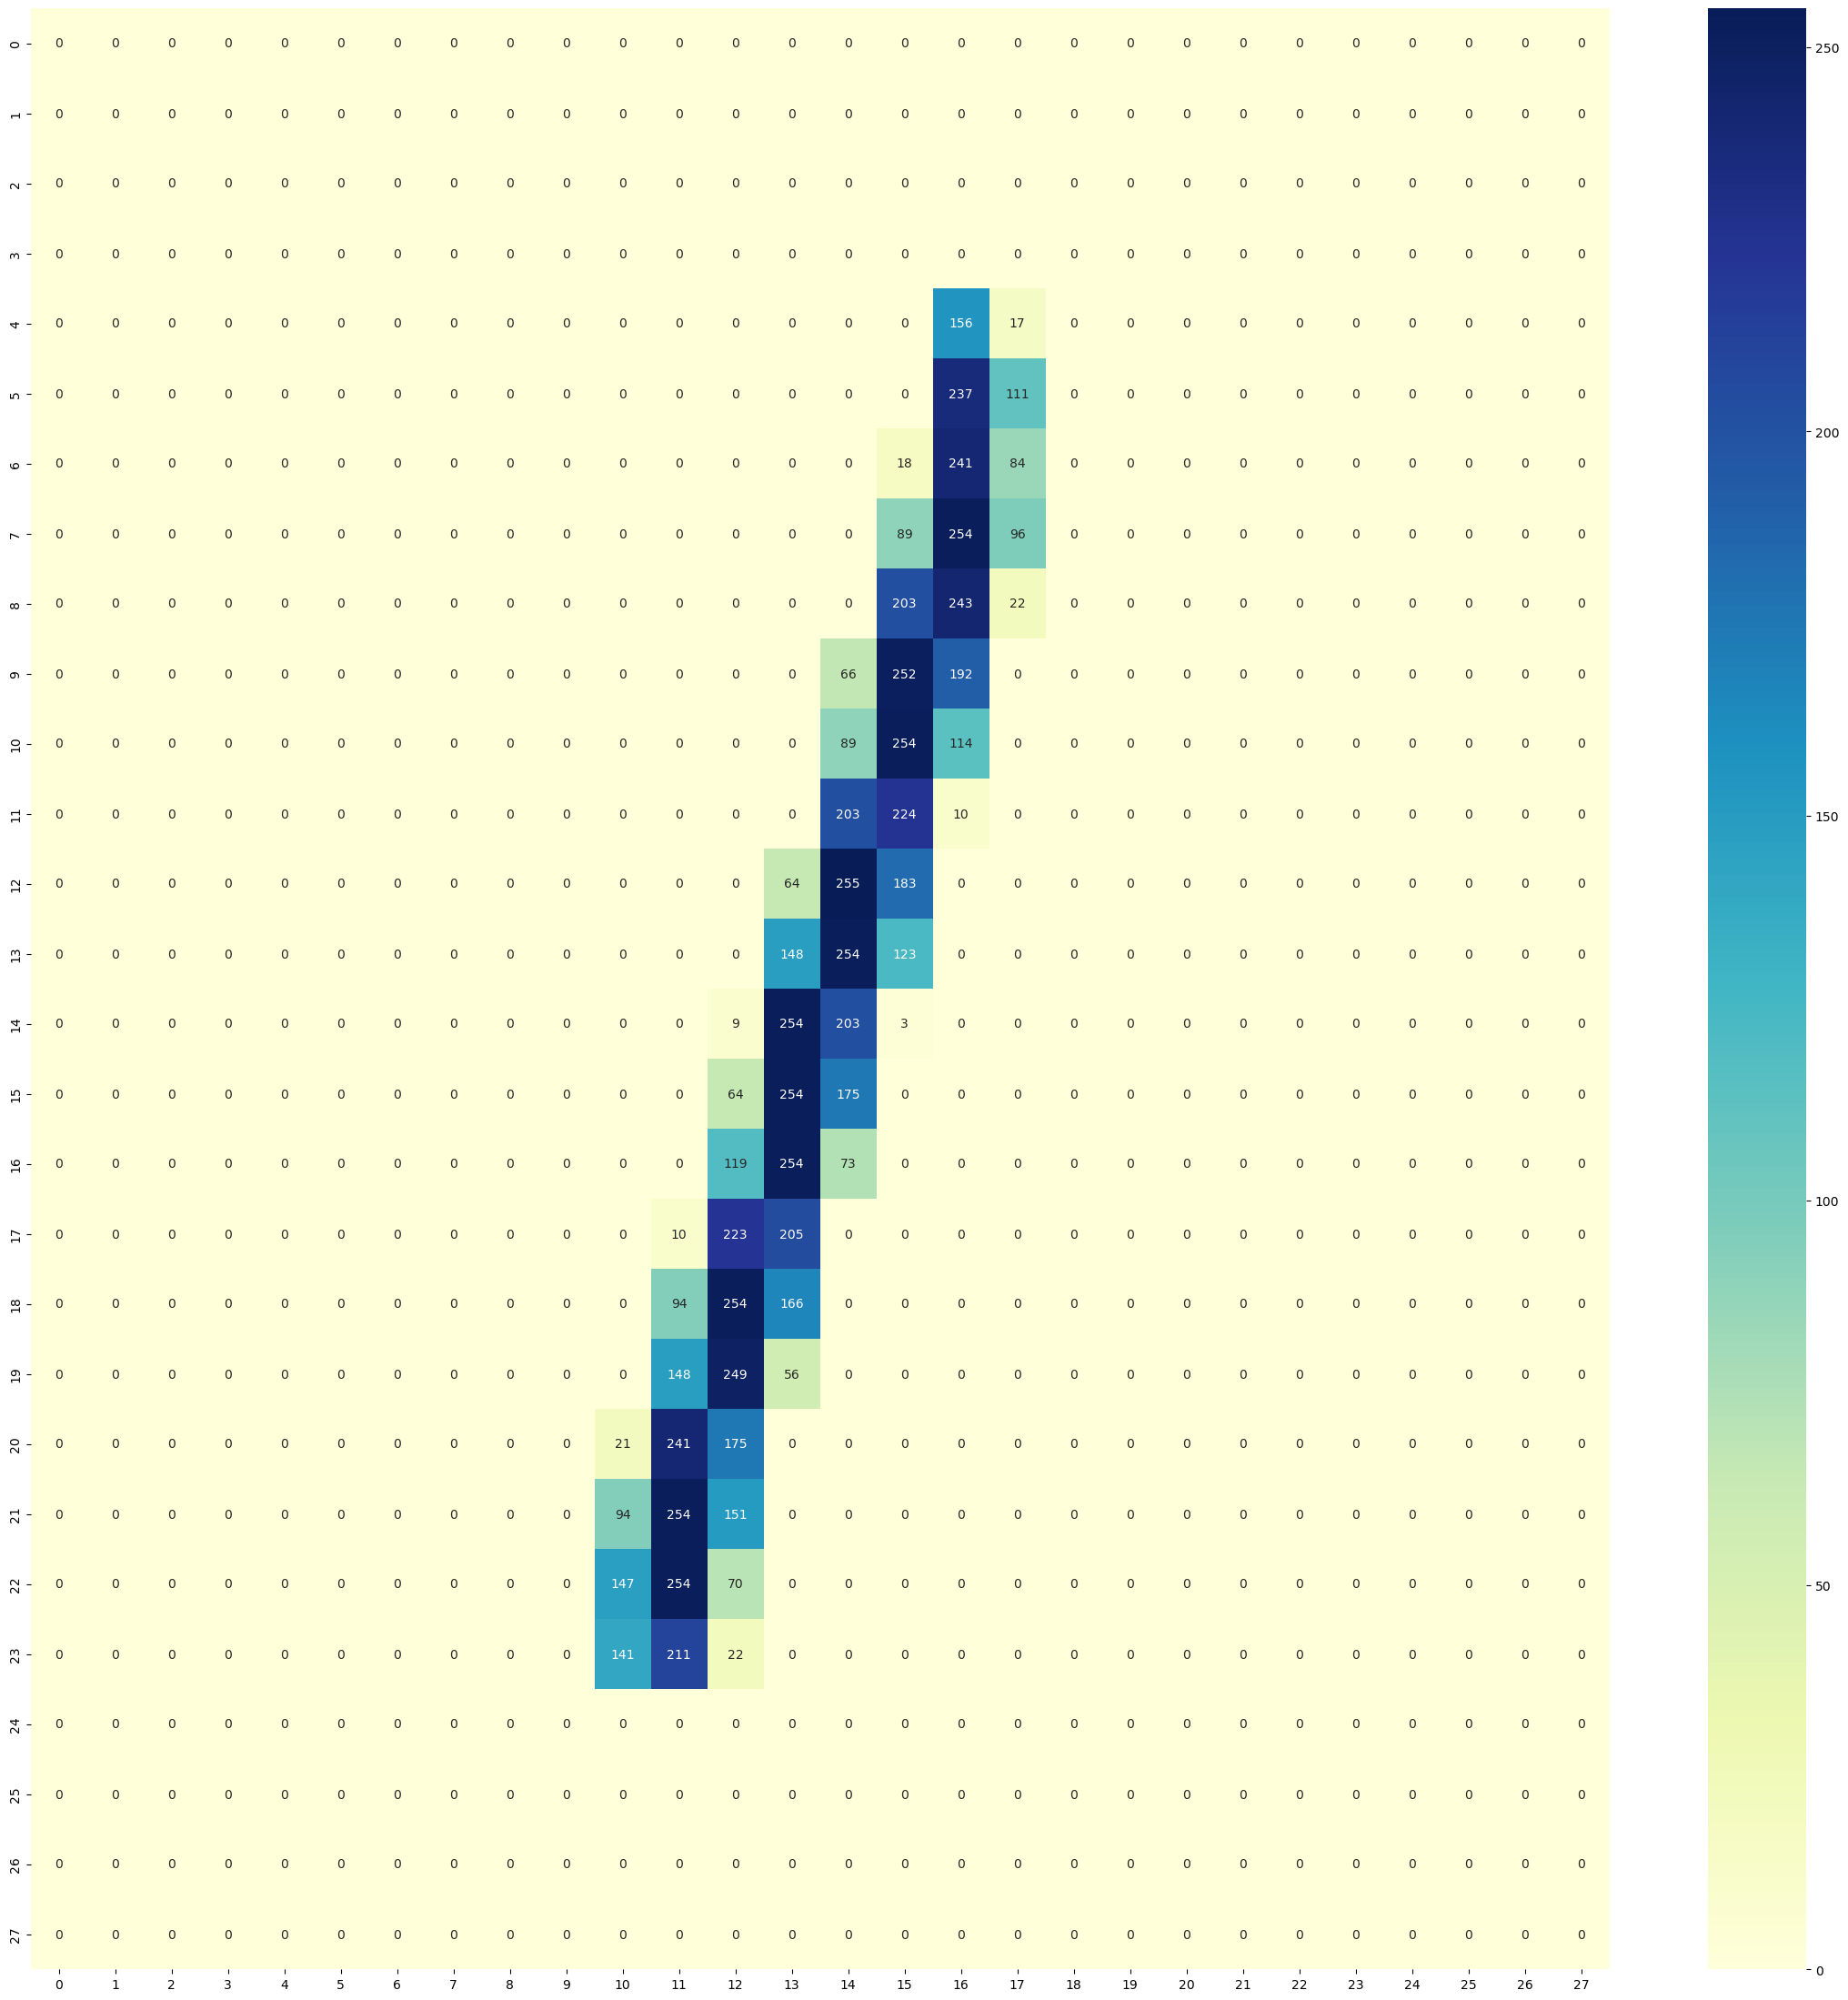

In [8]:
# lets recover 1 line and try to draw
import seaborn as sns
import matplotlib.pyplot as plt
from work_methods import matrix_recover

# choose a number between 1 and 2050 to draw
to_recover = 5
square_reference = 28

# define a matrix and rules
matrix = matrix_recover(all_data, to_recover, square_reference)

# heatmap plot of matrix
plt.figure(figsize=(28, 28))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## Next

In [ ]:
# python libraries
import optuna
import pandas as pd
import hiplot as hip 

# python codes
from resultado import Fold
from avaliacao import Experimento
from metodo import ScikitLearnAprendizadoDeMaquina

file_name = 'mnist_avaliacao.csv'

# define classes
numbers_names = ['0','1','2','3','4','5','6','7','8','9']
numbers_values = [x for x in range(0,10,1)]
numbers = dict(zip(numbers_values,numbers_names))

# recover DataFrame
df_data = pd.DataFrame(pd.read_csv(file_name))

#gera o fold e p experimento
folds = Fold.gerar_k_folds(df_data,val_k=5,col_classe='y_class',
                            num_repeticoes=1,seed=1,
                            num_folds_validacao=3,num_repeticoes_validacao=2)

In [ ]:
# randomForrestClassifier
from sklearn.ensemble import RandomForestClassifier
from avaliacao import OtimizacaoObjetivoRandomForest

clf_rf = RandomForestClassifier(random_state=1)
ml_method = ScikitLearnAprendizadoDeMaquina(clf_rf)
exp = Experimento(folds,ml_method, OtimizacaoObjetivoRandomForest, num_trials=10,
                    sampler=optuna.samplers.TPESampler(seed=1, n_startup_trials=3))
exp.calcula_resultados()

In [ ]:
studdy_fold_0 = exp.studies_per_fold[0]
studdy_fold_0.trials_dataframe().sort_values("value",ascending=False)